In [ ]:
import os
# os.chdir("/content/drive/My Drive/BMBC")
os.chdir("/content/drive/My Drive/BMBC")

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

# **BMBC 구조 설명**

In [ ]:
import torch
import os
import torchvision.transforms as T
from torchvision.utils import save_image
import cv2
import time

from utils import *
from flow_utils import *
from model import BMNet, FrameSynthesis

torch.no_grad()

first_dir = 'images/im1.png'
second_dir = 'images/im3.png'
output_dir = 'images/im2.png'
time_step = 0.5

In [ ]:
assert torch.cuda.is_available(), "GPU 런타임에 연결되지 않음!"

## **사전 준비**

### **모델 빌드**

In [ ]:
modules = dict()

modules['FeatureExtractor'] = nn.Sequential(nn.Conv2d(3, 64, (7, 7), stride=(1, 1), padding=(3, 3), bias=False),
                                            nn.ReLU())
modules['FlowEstimator'] = BMNet()
modules['FrameSynthesis'] = FrameSynthesis(32, 4, 16, 6)

### **모델 파라미터 불러오기**

In [ ]:
modules['FeatureExtractor'].load_state_dict(torch.load('Weights/context_layer.pth'))
modules['FlowEstimator'].load_state_dict(torch.load('Weights/BMNet_weights.pth'))
modules['FrameSynthesis'].load_state_dict(torch.load('Weights/Synthesis_weights.pth'))

<All keys matched successfully>

In [ ]:
for param in modules['FeatureExtractor'].parameters():
    param.requires_grad = False
for param in modules['FlowEstimator'].parameters():
    param.requires_grad = False
for param in modules['FrameSynthesis'].parameters():
    param.requires_grad = False

In [ ]:
modules['FlowEstimator'].cuda()
modules['FeatureExtractor'].cuda()
modules['FrameSynthesis'].cuda()

### **이미지 불러오기**

In [ ]:
I0 = cv2.cvtColor(cv2.imread(first_dir), cv2.COLOR_BGR2RGB)
I1 = cv2.cvtColor(cv2.imread(second_dir), cv2.COLOR_BGR2RGB)

I0 = T.ToTensor()(I0).unsqueeze(0).cuda()
I1 = T.ToTensor()(I1).unsqueeze(0).cuda()

## **중간 프레임 예측**

### **Optical Flow Estimator**

In [ ]:
F_0_1 = modules['FlowEstimator'](torch.cat((I0, I1), dim=1), time=0) * 2.0
F_1_0 = modules['FlowEstimator'](torch.cat((I0, I1), dim=1), time=1) * (-2.0)
BM = modules['FlowEstimator'](torch.cat((I0, I1), dim=1), time=time_step)

In [ ]:
F_0_1_save = F_0_1.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
F_1_0_save = F_1_0.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
BM_save = BM.cpu().data.numpy().transpose(0, 2, 3, 1)[0]

cv2.imwrite('flow1.png', cv2.cvtColor(flow2img((-time_step) * F_0_1_save), cv2.COLOR_RGB2BGR))
cv2.imwrite('flow2.png', cv2.cvtColor(flow2img((1 - time_step) * F_0_1_save), cv2.COLOR_RGB2BGR))
cv2.imwrite('flow3.png', cv2.cvtColor(flow2img(time_step * F_1_0_save), cv2.COLOR_RGB2BGR))
cv2.imwrite('flow4.png', cv2.cvtColor(flow2img((time_step - 1) * F_1_0_save), cv2.COLOR_RGB2BGR))
cv2.imwrite('flow5.png', cv2.cvtColor(flow2img(BM_save * (-2 * time_step)), cv2.COLOR_RGB2BGR))
cv2.imwrite('flow6.png', cv2.cvtColor(flow2img(BM_save * 2 * (1 - time_step)), cv2.COLOR_RGB2BGR))

True

### **Feature Extractor**

In [ ]:
Ctx0 = modules['FeatureExtractor'](I0)
Ctx1 = modules['FeatureExtractor'](I1)

### **Warping Layer**

In [ ]:
C1 = warp(torch.cat((I0, Ctx0), dim=1), (-time_step) * F_0_1)  # F_t_0
C2 = warp(torch.cat((I1, Ctx1), dim=1), (1 - time_step) * F_0_1)  # F_t_1
C3 = warp(torch.cat((I0, Ctx0), dim=1), time_step * F_1_0)  # F_t_0
C4 = warp(torch.cat((I1, Ctx1), dim=1), (time_step - 1) * F_1_0)  # F_t_1
C5 = warp(torch.cat((I0, Ctx0), dim=1), BM * (-2 * time_step))
C6 = warp(torch.cat((I1, Ctx1), dim=1), BM * 2 * (1 - time_step))

In [ ]:
W1 = C1[0][0:3]
W2 = C2[0][0:3]
W3 = C3[0][0:3]
W4 = C4[0][0:3]
W5 = C5[0][0:3]
W6 = C6[0][0:3]

save_image(W1, 'warp1.png')
save_image(W2, 'warp2.png')
save_image(W3, 'warp3.png')
save_image(W4, 'warp4.png')
save_image(W5, 'warp5.png')
save_image(W6, 'warp6.png')

### **Frame Synthesis**

In [ ]:
It = modules['FrameSynthesis'](torch.cat((I0, C1, C2, C3, C4, C5, C6, I1), dim=1))

### **결과 이미지 출력**

In [ ]:
It = (It[0].permute(1, 2, 0).cpu().data.numpy() * 255).round().astype('uint8')
cv2.imwrite(output_dir, cv2.cvtColor(It, cv2.COLOR_RGB2BGR))

True

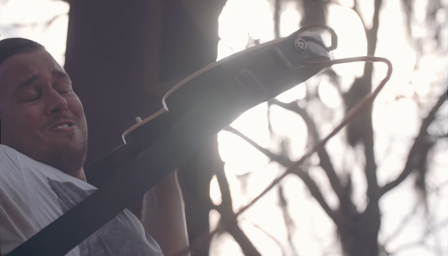

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

cv2_imshow(cv2.imread('images/im2.png'))

# **전체 코드**

In [ ]:
import torch
import os
import torchvision.transforms as T
from torchvision.utils import save_image
import cv2
import time

from utils import *
from flow_utils import *
from model import BMNet, FrameSynthesis

torch.no_grad()
assert torch.cuda.is_available(), "GPU 런타임에 연결되지 않음!"

tic = time.time()

first_dir = 'images/im1.png'
second_dir = 'images/im3.png'
output_dir = 'images/im2.png'
time_step = 0.5

# Build Models

modules = dict()

modules['FeatureExtractor'] = nn.Sequential(nn.Conv2d(3, 64, (7, 7), stride=(1, 1), padding=(3, 3), bias=False),
                                            nn.ReLU())
modules['FlowEstimator'] = BMNet()
modules['FrameSynthesis'] = FrameSynthesis(32, 4, 16, 6)

# Load Model Parameters

modules['FeatureExtractor'].load_state_dict(torch.load('Weights/context_layer.pth'))
modules['FlowEstimator'].load_state_dict(torch.load('Weights/BMNet_weights.pth'))
modules['FrameSynthesis'].load_state_dict(torch.load('Weights/Synthesis_weights.pth'))

for param in modules['FeatureExtractor'].parameters():
    param.requires_grad = False
for param in modules['FlowEstimator'].parameters():
    param.requires_grad = False
for param in modules['FrameSynthesis'].parameters():
    param.requires_grad = False

modules['FlowEstimator'].cuda()
modules['FeatureExtractor'].cuda()
modules['FrameSynthesis'].cuda()

# Open Images

I0 = cv2.cvtColor(cv2.imread(first_dir), cv2.COLOR_BGR2RGB)
I1 = cv2.cvtColor(cv2.imread(second_dir), cv2.COLOR_BGR2RGB)

I0 = T.ToTensor()(I0).unsqueeze(0).cuda()
I1 = T.ToTensor()(I1).unsqueeze(0).cuda()

# Optical Flow Estimator

F_0_1 = modules['FlowEstimator'](torch.cat((I0, I1), dim=1), time=0) * 2.0
F_1_0 = modules['FlowEstimator'](torch.cat((I0, I1), dim=1), time=1) * (-2.0)
BM = modules['FlowEstimator'](torch.cat((I0, I1), dim=1), time=time_step)  # V_t_1

# Feature Extractor

Ctx0 = modules['FeatureExtractor'](I0)
Ctx1 = modules['FeatureExtractor'](I1)

# Warping Layer

C1 = warp(torch.cat((I0, Ctx0), dim=1), (-time_step) * F_0_1)  # F_t_0
C2 = warp(torch.cat((I1, Ctx1), dim=1), (1 - time_step) * F_0_1)  # F_t_1
C3 = warp(torch.cat((I0, Ctx0), dim=1), time_step * F_1_0)  # F_t_0
C4 = warp(torch.cat((I1, Ctx1), dim=1), (time_step - 1) * F_1_0)  # F_t_1
C5 = warp(torch.cat((I0, Ctx0), dim=1), BM * (-2 * time_step))
C6 = warp(torch.cat((I1, Ctx1), dim=1), BM * 2 * (1 - time_step))

# Frame Synthesis

It = modules['FrameSynthesis'](torch.cat((I0, C1, C2, C3, C4, C5, C6, I1), dim=1))

# Save Prediction

It = (It[0].permute(1, 2, 0).cpu().data.numpy() * 255).round().astype('uint8')
cv2.imwrite(output_dir, cv2.cvtColor(It, cv2.COLOR_RGB2BGR))

print("%.2f sec elapsed." % (time.time() - tic))


1.17 sec


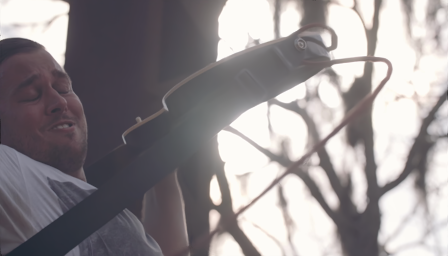

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(cv2.imread('images/im2.png'))